In [51]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, SpatialDropout2D, InputLayer, Rescaling
from keras.utils import image_dataset_from_directory
from keras.callbacks import  ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


data_dir = "/home/yutharsan/Desktop/EN3150-Assignment-03-DeepMind/datasets/realwaste-main/RealWaste"
img_size = (128, 128)
batch_size = 64

dataset = image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=123
)


Found 4752 files belonging to 9 classes.


In [52]:
# Split dataset (70/15/15)

dataset_size = len(dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [53]:
# CNN Model

def cnn_model(input_shape = (128, 128, 3)):
    """
    CNN model consists of 4 convolutional blocks with increasing spatial dropouts to facilitate regularization in deeper convolutional
    layers.
    ReLU activated dense layer with considerable dropout is applied for clasification
    SoftMax activated output layer produces one-hot encoded classification
    """

    model = Sequential()
    model.add(InputLayer(shape=input_shape))

    # Convolution Block 1 - 32 filters : max pooling
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    # Convolution Block 2 - 64 filters : max pooling : spatial dropout
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(SpatialDropout2D(0.1))

    # Convolution Block 3 - 128 filters : max pooling : spatial dropout
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(SpatialDropout2D(0.1))

    # Convolution Block 4 - 256 filters : max pooling : spatial dropout
    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(SpatialDropout2D(0.2))

    # Flatten layer
    model.add(Flatten())
    # Dense layer - 512 neurons : dropout
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer - 9 neurons
    model.add(Dense(len(dataset.class_names), activation='softmax'))

    return model

In [54]:
model = cnn_model()
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_27            │ (None, 30, 30, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_28            │ (None, 14, 14, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_29            │ (None, 6, 6, 256)      │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,114,057 (19.51 MB)

 Trainable params: 5,113,097 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [55]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=2, min_lr=1e-8)

In [56]:
# Compile
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:

# Train (20 epochs)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ reduce_lr]
)


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.3645 - loss: 3.3592 - val_accuracy: 0.1094 - val_loss: 6.5141 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - accuracy: 0.3645 - loss: 3.3592 - val_accuracy: 0.1094 - val_loss: 6.5141 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4868 - loss: 1.5465 - val_accuracy: 0.1932 - val_loss: 3.0701 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4868 - loss: 1.5465 - val_accuracy: 0.1932 - val_loss: 3.0701 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5472 - loss: 1.3336 - val_accuracy: 0.3480 - val_loss: 2.6973 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5472 - loss: 1.3336 - val_accuracy: 0.3480 - val_loss: 2.6973 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5862 - loss: 1.1882 - val

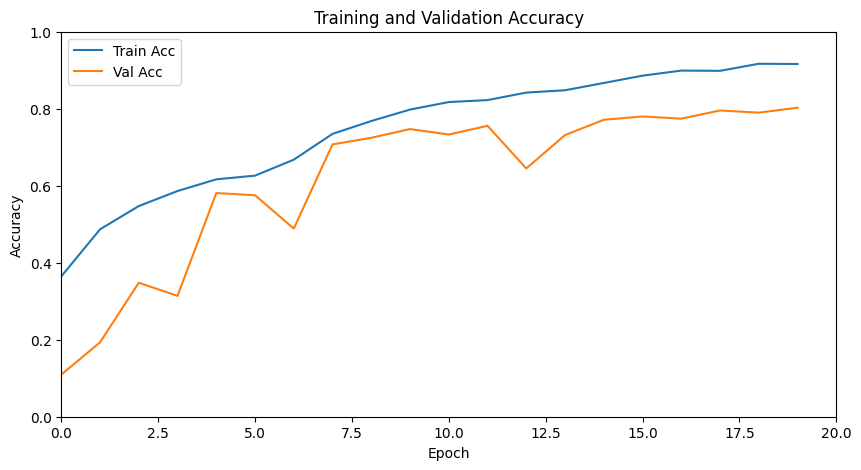

In [58]:
# Plot Accuracy
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.xlim(0, 20)
plt.legend()
plt.show()


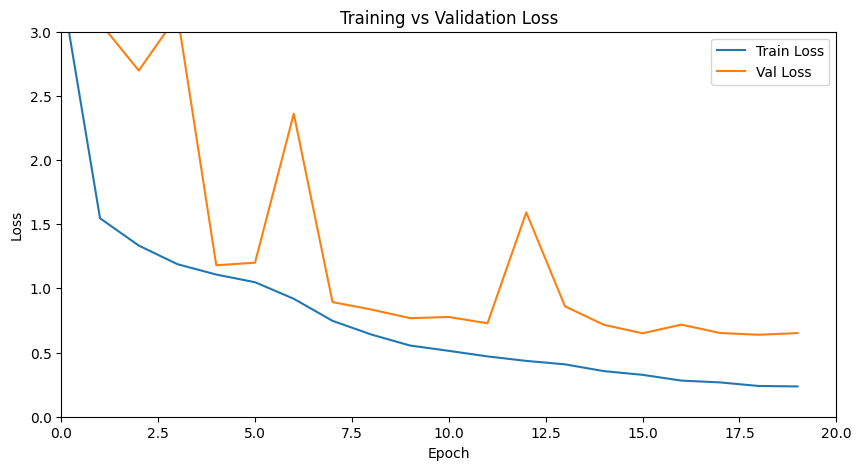

In [59]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3.0)
plt.xlim(0, 20)
plt.legend()
plt.show()

In [60]:
# Evaluate - Precision, recall, f1-score

test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)

# Convert one hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=dataset.class_names))


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7264 - loss: 0.8618
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7264 - loss: 0.8618
Test Accuracy: 0.7264
Test Accuracy: 0.7264
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
                     precision    recall  f1-score   support

          Cardboard       0.90      0.65      0.76        69
      Food Organics       0.75      0.75      0.75        57
              Glass       0.82      0.77      0.80        53
              Metal       0.71      0.74      0.73       131
Miscellaneous Trash       0.57      0.68      0.62        72
              Paper       0.71      0.67      0.69        67
            Plastic       0.67      0.73      0.70       143
      Textile Trash       0.76      0.56      0.65        55
         Vegetation       0.84      0.93      0.88        73

           accuracy                           0.73       720
          macro avg       0.75      0.72      0.73     

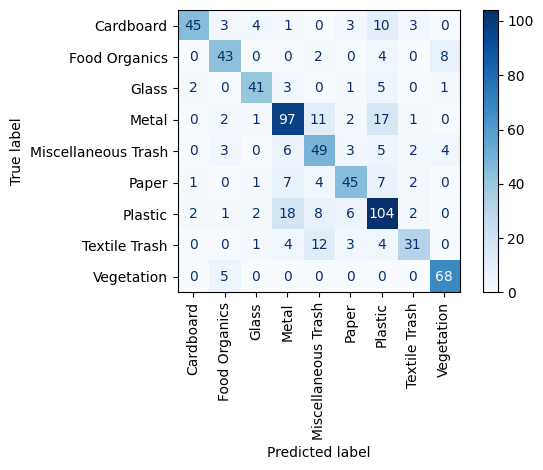

In [61]:
# Evaluate - Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.tight_layout()
plt.show()


In [62]:
# Model with SGD as optimizer
model_sgd = cnn_model()

# Compile SGD
optimizer_sgd = keras.optimizers.SGD(learning_rate=0.001)
model_sgd.compile(optimizer=optimizer_sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd = model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ reduce_lr]
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.1980 - loss: 3.4684 - val_accuracy: 0.1946 - val_loss: 2.3436 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.1980 - loss: 3.4684 - val_accuracy: 0.1946 - val_loss: 2.3436 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2788 - loss: 2.6802 - val_accuracy: 0.1861 - val_loss: 2.1499 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.2788 - loss: 2.6802 - val_accuracy: 0.1861 - val_loss: 2.1499 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3215 - loss: 2.3253 - val_accuracy: 0.2841 - val_loss: 1.9114 - learning_rate: 4.0000e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3215 - loss: 2.3253 - val_accuracy: 0.2841 - val_loss: 1.9114 - learning_rate: 4.0000e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.3296 - loss: 2.2590 -

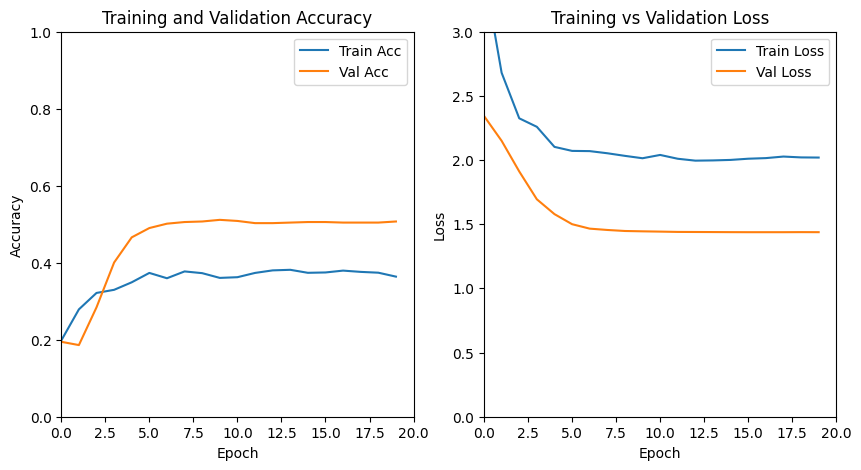

In [63]:
# Plot Accuracy SGD
figure, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 5))


plt1.plot(history_sgd.history['accuracy'], label='Train Acc')
plt1.plot(history_sgd.history['val_accuracy'], label='Val Acc')
plt1.set_title('Training and Validation Accuracy')
plt1.set_xlabel('Epoch')
plt1.set_ylabel('Accuracy')
plt1.set_ylim(0, 1.0)
plt1.set_xlim(0, 20)
plt1.legend()

plt2.plot(history_sgd.history['loss'], label='Train Loss')
plt2.plot(history_sgd.history['val_loss'], label='Val Loss')
plt2.set_title('Training vs Validation Loss')
plt2.set_xlabel('Epoch')
plt2.set_ylabel('Loss')
plt2.set_ylim(0, 3.0)
plt2.set_xlim(0, 20)
plt2.legend()

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.4694 - loss: 1.5781
Test Accuracy: 0.4694


2025-10-30 19:41:49.203402: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
                     precision    recall  f1-score   support

          Cardboard       0.45      0.30      0.36        69
      Food Organics       0.46      0.49      0.47        57
              Glass       0.45      0.64      0.53        53
              Metal       0.47      0.53      0.50       131
Miscellaneous Trash       0.32      0.17      0.22        72
              Paper       0.35      0.33      0.34        67
            Plastic       0.51      0.55      0.53       143
      Textile Trash       0.27      0.13      0.17        55
         Vegetation       0.61      0.89      0.73        73

           accuracy                           0.47       720
          macro avg       0.43      0.45      0.43       720
       weighted avg       0.45      0.47      0.45       720



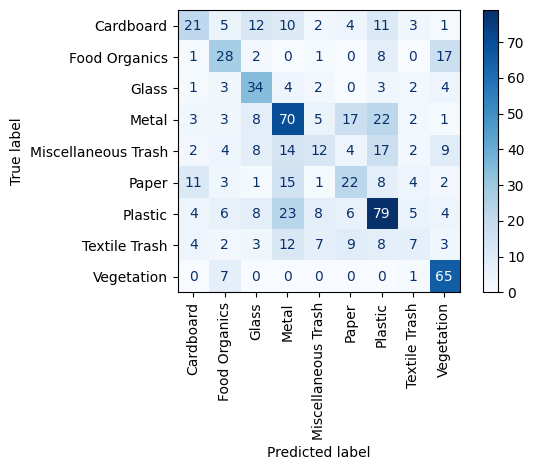

In [ ]:
# Evaluate - Precision, recall, f1-score

test_loss, test_acc = model_sgd.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model_sgd.predict(test_ds)

# Convert one hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=dataset.class_names))


# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.tight_layout()
plt.show()


In [65]:
# Model with SGD wit Momentum as optimizer
model_sgd_m = cnn_model()

# Compile SGD
optimizer_sgd_m = keras.optimizers.SGD(learning_rate=0.001, momentum=0.8)
model_sgd_m.compile(optimizer=optimizer_sgd_m,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_sgd_m = model_sgd_m.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[ reduce_lr]
)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.2834 - loss: 2.8353 - val_accuracy: 0.1974 - val_loss: 3.0956 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.2834 - loss: 2.8353 - val_accuracy: 0.1974 - val_loss: 3.0956 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4375 - loss: 1.7321 - val_accuracy: 0.2173 - val_loss: 2.3447 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4375 - loss: 1.7321 - val_accuracy: 0.2173 - val_loss: 2.3447 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4871 - loss: 1.4921 - val_accuracy: 0.2727 - val_loss: 2.2132 - learning_rate: 4.0000e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.4871 - loss: 1.4921 - val_accuracy: 0.2727 - val_loss: 2.2132 - learning_rate: 4.0000e-04
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5198 - loss: 1.3799

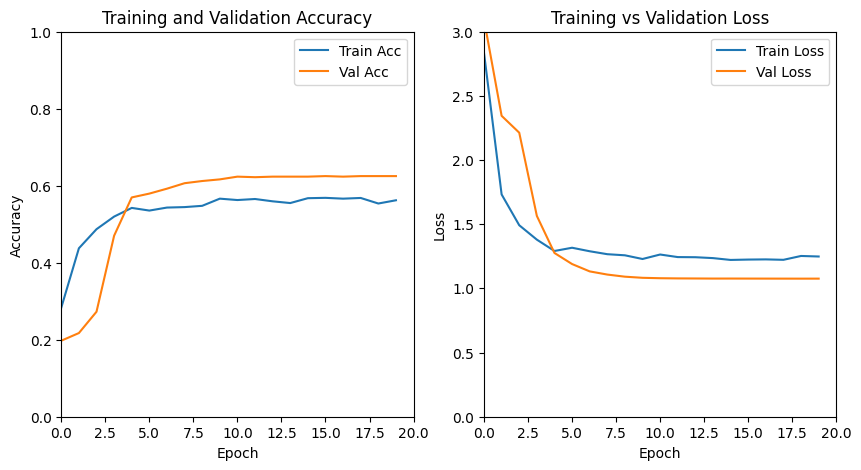

In [66]:
# Plot Accuracy SGD
figure, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 5))


plt1.plot(history_sgd_m.history['accuracy'], label='Train Acc')
plt1.plot(history_sgd_m.history['val_accuracy'], label='Val Acc')
plt1.set_title('Training and Validation Accuracy')
plt1.set_xlabel('Epoch')
plt1.set_ylabel('Accuracy')
plt1.set_ylim(0, 1.0)
plt1.set_xlim(0, 20)
plt1.legend()

plt2.plot(history_sgd_m.history['loss'], label='Train Loss')
plt2.plot(history_sgd_m.history['val_loss'], label='Val Loss')
plt2.set_title('Training vs Validation Loss')
plt2.set_xlabel('Epoch')
plt2.set_ylabel('Loss')
plt2.set_ylim(0, 3.0)
plt2.set_xlim(0, 20)
plt2.legend()

 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6094 - loss: 1.1471

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5625 - loss: 1.2139
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.5625 - loss: 1.2139
Test Accuracy: 0.5625
Test Accuracy: 0.5625
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
                     precision    recall  f1-score   support

          Cardboard       0.55      0.51      0.53        69
      Food Organics       0.59      0.70      0.64        57
              Glass       0.69      0.66      0.67        53
              Metal       0.59      0.67      0.63       131
Miscellaneous Trash       0.42      0.32      0.36        72
              Paper       0.45      0.37      0.41        67
            Plastic       0.49      0.55      0.52       143
      Textile Trash       0.54      0.24      0.33        55
         Vegetation       0.72      0.93      0.81        73

           accuracy                           0.56       720
          macro avg       0.56      0.55      0.54     

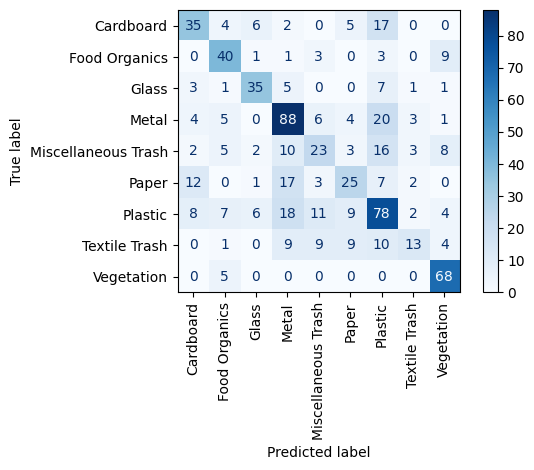

In [ ]:
# Evaluate - Precision, recall, f1-score

test_loss, test_acc = model_sgd_m.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model_sgd_m.predict(test_ds)

# Convert one hot encoded labels to class indices
y_true_classes = np.argmax(y_true, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=dataset.class_names))


# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.tight_layout()
plt.show()
